# Pre-trained Models
 - Detoxify, Perspective API

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install detoxify

In [ ]:
import pandas as pd
import numpy as np
import requests
import torch
import os
import re
import torch.nn.functional as F
from detoxify import Detoxify

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
base_path = "/content/drive/MyDrive/MRP_Offensive_Content_Detection/Final_Dataset/"
df = pd.read_csv(base_path + 'mrp_final_dataset.csv')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label'] = le.fit_transform(df['majority_label'])  # Maps labels to integers

In [ ]:
from sklearn.model_selection import train_test_split
train_eval_df, final_test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
final_test_df.to_csv('final_test_dataset.csv', index=False)

In [ ]:
API_KEY = ''
API_URL = f'https://commentanalyzer.googleapis.com/v1alpha1/comments:analyze?key={API_KEY}'
import time

def get_perspective_score(text):
    headers = {
        'Content-Type': 'application/json'
    }
    data = {
        'comment': {'text': text},
        'languages': ['en'],
        'requestedAttributes': {'INSULT': {}},
        'doNotStore': True  # Optional, for privacy
    }
    # time.sleep(1)
    response = requests.post(API_URL, headers=headers, json=data)
    if response.status_code == 200:
        result = response.json()
        score = result['attributeScores']['INSULT']['summaryScore']['value']
        return score
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

In [ ]:
detoxify_model = Detoxify('original')

Downloading: "https://github.com/unitaryai/detoxify/releases/download/v0.1-alpha/toxic_original-c1212f89.ckpt" to /root/.cache/torch/hub/checkpoints/toxic_original-c1212f89.ckpt
100%|██████████| 418M/418M [00:02<00:00, 203MB/s]


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def get_detoxify_score(text):
    result = detoxify_model.predict(text)
    return result.get("insult", 0)

def get_model_label(score, threshold=0.5):
    return int(score >= threshold)

In [ ]:
import os
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

batch_size = 120
MAX_LENGTH = 62

# Initialize lists to store true and predicted labels
all_true_labels = []
all_pred_labels_detoxify = []
all_pred_labels_perspective = []

batch_size = 200

for chunk in pd.read_csv('final_test_dataset.csv', chunksize=batch_size):
    chunk['text'] = chunk['text'].apply(lambda x: ' '.join(x.split()[:MAX_LENGTH]))

    # Model predictions (assuming these functions exist and output scores)
    chunk['detoxify_score'] = chunk['text'].apply(get_detoxify_score)
    chunk['perspective_score'] = chunk['text'].apply(get_perspective_score)

    # Get predicted labels using your thresholding or labeling function
    chunk['label_detoxify'] = chunk['detoxify_score'].apply(get_model_label)
    chunk['label_perspective'] = chunk['perspective_score'].apply(get_model_label)

    # Append true labels and predicted labels for evaluation
    all_true_labels.extend(chunk['label'].tolist())
    all_pred_labels_detoxify.extend(chunk['label_detoxify'].tolist())
    all_pred_labels_perspective.extend(chunk['label_perspective'].tolist())

    # Save chunk with predictions to CSV
    output_path = 'output_predictions.csv'
    chunk.to_csv(output_path, mode='a', index=False,
                 header=not os.path.exists(output_path))
    print(f"Processed a batch of {len(chunk)} rows and saved to {output_path}.")

print("Completed processing dataset.")

Processed a batch of 200 rows and saved to output_predictions.csv.
Processed a batch of 200 rows and saved to output_predictions.csv.
Processed a batch of 200 rows and saved to output_predictions.csv.
Processed a batch of 200 rows and saved to output_predictions.csv.
Processed a batch of 200 rows and saved to output_predictions.csv.
Processed a batch of 200 rows and saved to output_predictions.csv.
Processed a batch of 93 rows and saved to output_predictions.csv.
Completed processing dataset.



=== Detoxify Model Classification Report ===
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       576
           1       0.98      0.09      0.16       717

    accuracy                           0.49      1293
   macro avg       0.73      0.54      0.40      1293
weighted avg       0.75      0.49      0.37      1293



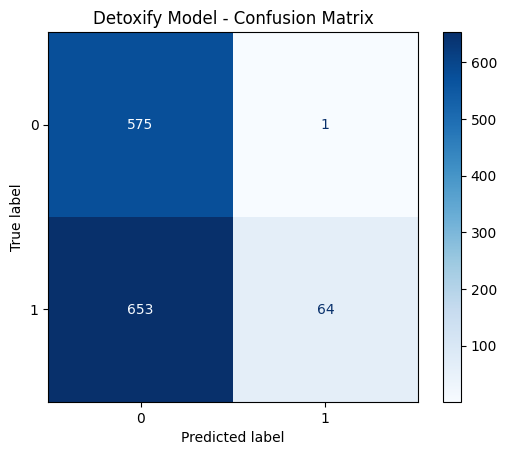

In [ ]:
# After processing all chunks, evaluate Detoxify predictions
print("\n=== Detoxify Model Classification Report ===")
print(classification_report(all_true_labels, all_pred_labels_detoxify))

cm_detoxify = confusion_matrix(all_true_labels, all_pred_labels_detoxify)
disp_detoxify = ConfusionMatrixDisplay(confusion_matrix=cm_detoxify)
disp_detoxify.plot(cmap='Blues')
plt.title("Detoxify Model - Confusion Matrix")
plt.show()


=== Perspective Model Classification Report ===
              precision    recall  f1-score   support

           0       0.52      0.97      0.68       576
           1       0.92      0.28      0.43       717

    accuracy                           0.59      1293
   macro avg       0.72      0.63      0.56      1293
weighted avg       0.74      0.59      0.54      1293



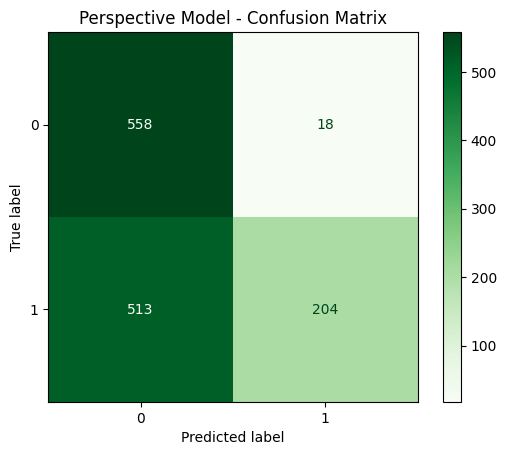

In [ ]:
# Evaluate Perspective predictions similarly
print("\n=== Perspective Model Classification Report ===")
print(classification_report(all_true_labels, all_pred_labels_perspective))

cm_perspective = confusion_matrix(all_true_labels, all_pred_labels_perspective)
disp_perspective = ConfusionMatrixDisplay(confusion_matrix=cm_perspective)
disp_perspective.plot(cmap='Greens')
plt.title("Perspective Model - Confusion Matrix")
plt.show()

# Find Optimum Threshold for pre-trained models

In [ ]:
df = pd.read_csv('output_predictions.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293 entries, 0 to 1292
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               1293 non-null   object 
 1   majority_label     1293 non-null   object 
 2   label              1293 non-null   int64  
 3   detoxify_score     1293 non-null   float64
 4   perspective_score  1293 non-null   float64
 5   label_detoxify     1293 non-null   int64  
 6   label_perspective  1293 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 70.8+ KB


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_scores, model_name="Model"):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'{model_name} ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # Find optimal threshold using Youden's J statistic
    optimal_idx = (tpr - fpr).argmax()
    optimal_threshold = thresholds[optimal_idx]
    print(f"Optimal threshold by Youden's J statistic: {optimal_threshold:.3f}")

    return fpr, tpr, thresholds, roc_auc, optimal_threshold

## ROC Curve - optimum threshold for Detoxify model

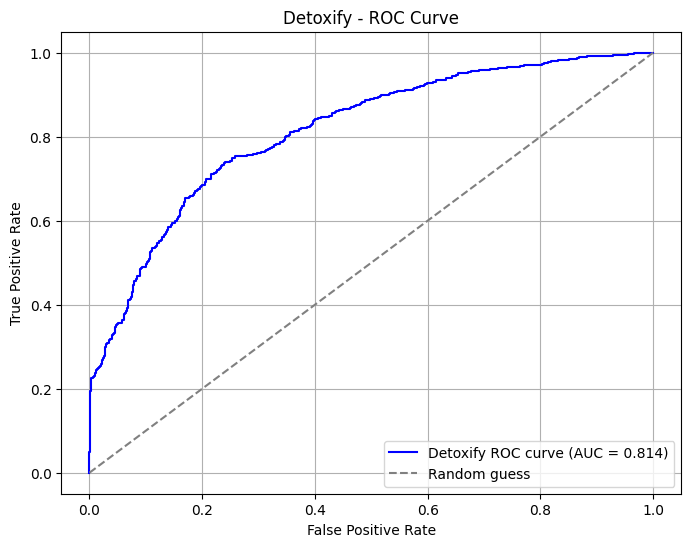

Optimal threshold by Youden's J statistic: 0.000


(array([0.        , 0.        , 0.        , 0.00173611, 0.00173611,
        0.00347222, 0.00347222, 0.00520833, 0.00520833, 0.00694444,
        0.00694444, 0.00868056, 0.00868056, 0.01041667, 0.01041667,
        0.01215278, 0.01215278, 0.01388889, 0.01388889, 0.015625  ,
        0.015625  , 0.01736111, 0.01736111, 0.01909722, 0.01909722,
        0.02083333, 0.02083333, 0.02256944, 0.02256944, 0.02430556,
        0.02430556, 0.02604167, 0.02604167, 0.02777778, 0.02777778,
        0.02951389, 0.02951389, 0.03125   , 0.03125   , 0.03472222,
        0.03472222, 0.03645833, 0.03645833, 0.03993056, 0.03993056,
        0.04166667, 0.04166667, 0.04340278, 0.04340278, 0.04513889,
        0.04513889, 0.046875  , 0.046875  , 0.04861111, 0.04861111,
        0.05034722, 0.05034722, 0.05381944, 0.05381944, 0.05729167,
        0.05729167, 0.06076389, 0.06076389, 0.0625    , 0.0625    ,
        0.06423611, 0.06423611, 0.06597222, 0.06597222, 0.06770833,
        0.06770833, 0.07118056, 0.07118056, 0.07

In [ ]:
# Example usage:
y_true = df['label']
y_scores = df['detoxify_score']
plot_roc_curve(y_true, y_scores, model_name="Detoxify")

## ROC Curve - optimum threshold for Perspective API

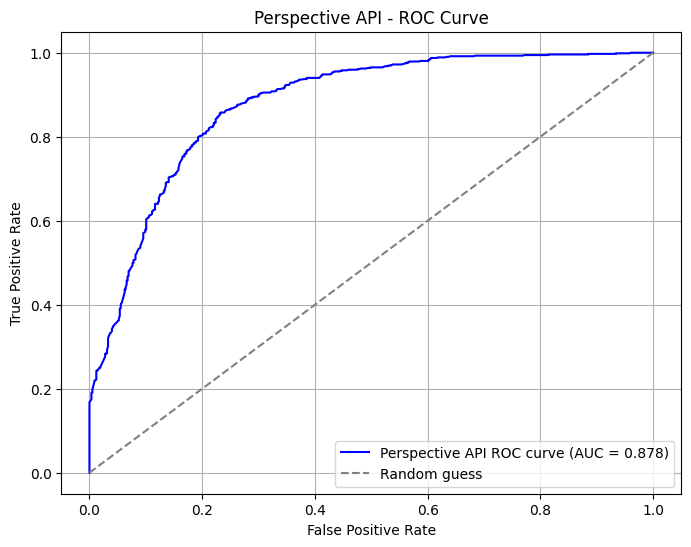

Optimal threshold by Youden's J statistic: 0.056


(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00173611, 0.00347222, 0.00347222, 0.00520833, 0.00520833,
        0.00868056, 0.00868056, 0.01215278, 0.01215278, 0.01215278,
        0.01215278, 0.01215278, 0.01388889, 0.01388889, 0.015625  ,
        0.01736111, 0.01909722, 0.01909722, 0.02777778, 0.02777778,
        0.02777778, 0.02951389, 0.02951389, 0.03125   , 0.03125   ,
        0.03125   , 0.03298611, 0.03298611, 0.03298611, 0.03298611,
        0.03298611, 0.03298611, 0.03298611, 0.03645833, 0.03819444,
        0.03993056, 0.03993056, 0.04166667, 0.04

In [ ]:
y_true = df['label']
y_scores = df['perspective_score']
plot_roc_curve(y_true, y_scores, model_name="Perspective API")

# Threshold Optimization on Perspective API

In [ ]:
PERSPECTIVE_OPTIMAL_THRESHOLD = 0.056

def get_perspective_label(score):
    return 1 if score >= PERSPECTIVE_OPTIMAL_THRESHOLD else 0

In [ ]:
df['label_perspective_new'] = df['perspective_score'].apply(get_perspective_label)
all_pred_labels_perspective = df['label_perspective_new'].tolist()


=== Perspective Model Classification Report ===
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       576
           1       0.82      0.85      0.84       717

    accuracy                           0.82      1293
   macro avg       0.82      0.81      0.81      1293
weighted avg       0.82      0.82      0.82      1293



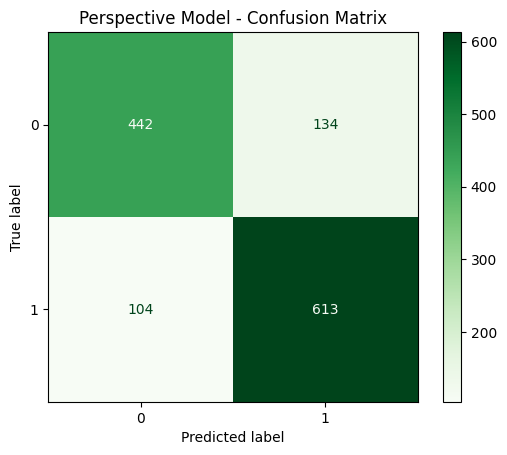

In [ ]:
# Evaluate Perspective predictions similarly
print("\n=== Perspective Model Classification Report NEW ===")
print(classification_report(all_true_labels, all_pred_labels_perspective))

cm_perspective = confusion_matrix(all_true_labels, all_pred_labels_perspective)
disp_perspective = ConfusionMatrixDisplay(confusion_matrix=cm_perspective)
disp_perspective.plot(cmap='Blues')
plt.title("Perspective Model - Confusion Matrix")
plt.show()

*Observation:*
- Threshold tuning created a solid baseline, with balanced precision and recall and F1 score of 0.84 for Offensive class

# Threshold Optimization on Detoxify Model

In [ ]:
DETOXIFY_OPTIMAL_THRESHOLD = 0.0

def get_detoxify_label(score):
    return 1 if score >= DETOXIFY_OPTIMAL_THRESHOLD else 0

In [ ]:
df['label_detoxify_new'] = df['detoxify_score'].apply(get_detoxify_label)
all_pred_labels_detoxify = df['label_detoxify_new'].tolist()


=== Detoxify Model Classification Report NEW ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       576
           1       0.55      1.00      0.71       717

    accuracy                           0.55      1293
   macro avg       0.28      0.50      0.36      1293
weighted avg       0.31      0.55      0.40      1293



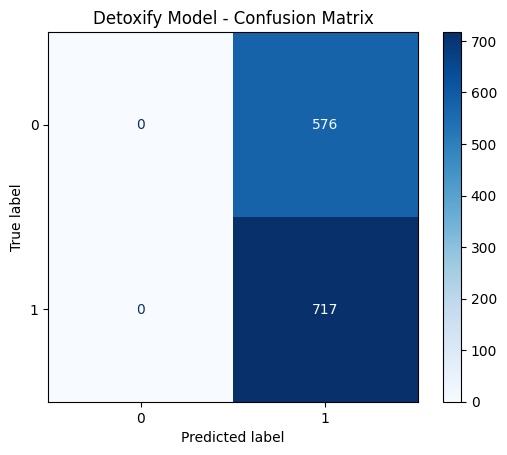

In [ ]:
# Evaluate Perspective predictions similarly
print("\n=== Detoxify Model Classification Report NEW ===")
print(classification_report(all_true_labels, all_pred_labels_detoxify))

cm_detoxify = confusion_matrix(all_true_labels, all_pred_labels_detoxify)
disp_detoxify = ConfusionMatrixDisplay(confusion_matrix=cm_detoxify)
disp_detoxify.plot(cmap='Blues')
plt.title("Detoxify Model - Confusion Matrix")
plt.show()

*Observation:*
- Threshold optimization failed for Detoxify Model (model predicts everything as offensive) making it unreliable